In [2]:
import numpy as np

# packages for plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   ,
            'figure.dpi': 300
           })

##### MLP

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class mlp(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(mlp, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    

    def forward(self,x):
        h = torch.relu(self.fc1(x))
        h = self.fc2(h)
        return h.squeeze()

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)



#------ MLP 1: generative model ------#

def generatedata(Din, hidden_dim=64, num_samples=500):
    # generate # data points with the dimensionality of Din
    hidden_dim = 64
    gen_model = mlp(Din,hidden_dim)
    gen_model.apply(weights_init)
    gen_model.eval()

    with torch.no_grad():
        features = torch.torch.distributions.Uniform(low=-2, high=2).sample((num_samples,Din))
        labels = gen_model(features) + torch.normal(0., 0.1, size=(1,num_samples)).squeeze()
    return features, labels

#--------- Noising the data ----------#

def noising(data, xnoiselevel, ynoiselevel, threshold=0, noise_region='above', plot=True):
    x, y = data
    x = x.numpy()
    y = y.numpy()
    if noise_region == 'above':
        xnoise = xnoiselevel * np.random.normal(size=x.shape) * np.select([y>threshold],[1], 0).reshape(-1,1)
        ynoise = ynoiselevel * np.random.normal(size=y.shape) * np.select([y>threshold],[1], 0)
    elif noise_region == 'below':
        xnoise = xnoiselevel * np.random.normal(size=x.shape) * np.select([y<threshold],[1], 0).reshape(-1,1)
        ynoise = ynoiselevel * np.random.normal(size=y.shape) * np.select([y<threshold],[1], 0)
    else:
          raise Exception("'targetregion' argument can only accept 'below' or 'above'")
    xn = x + np.float32(xnoise)
    yn = y + np.float32(ynoise)
    if plot:
      # to be certain only desired region is noised
      # no method of verifying xn vs y yet
        plt.scatter(y,yn)
        plt.title('sanity check: noised y vs. raw y')
        plt.show()
    return torch.tensor(xn), torch.tensor(yn)

#------ MLP 2: the actual model ------#

def train(model, data, optimizer, num_epochs=50):
    model.train()
    features, labels = data
    losses = []
    for epoch in range(num_epochs):
        pred = model(features)
        loss = F.mse_loss(pred,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.4f}')
    return losses


def local_mse(y,yhat, min, max):
    y, yhat = torch.tensor(y), torch.tensor(yhat)
    mask = (y >= min) & (y <= max)
    local_y = y[mask]
    local_yhat = yhat[mask]
    local_mse = F.mse_loss(local_yhat, local_y)
    return local_mse.item()

def filterdata_by_label(data, threshold, omitregion):
    if omitregion not in ['above', 'below']:
        raise ValueError("omitregion must be either 'above' or 'below'")
    x,y = data
    filtered_x = []
    filtered_y = []
    print(x)
    
    for i, label in enumerate(y):
        if omitregion == 'above':
            if label < threshold:
                filtered_x.append(x[i])
                filtered_y.append(label)
        else:
            if label > threshold:
                filtered_x.append(x[i])
                filtered_y.append(label)
    
    if len(filtered_x) == 1:
        filtered_x = filtered_x[0]
    else:
        x_shape = filtered_x[0].shape
        filtered_x = torch.stack(filtered_x).reshape(len(filtered_x), *x_shape)
        
    if len(filtered_y) == 1:
        filtered_y = filtered_y[0]
    else:
        filtered_y = torch.tensor(filtered_y)
        
    return filtered_x, filtered_y

In [4]:
Din = 50
hidden_dim = 64
num_epochs = 60
num_samples = 2000
data = generatedata(Din, hidden_dim, num_samples)
features, labels = data
# print('Generated Labels:', labels.tolist())
# plt.hist(labels)
# plt.show()

###### Omission baseline

tensor([[-1.5570,  0.5431, -1.5496,  ..., -1.1784, -0.6377, -1.6664],
        [ 0.1072, -0.1074,  1.7866,  ...,  1.8179, -0.2341,  1.1696],
        [-0.2733, -1.7472,  0.5024,  ..., -1.9449,  1.9580, -1.0572],
        ...,
        [ 1.5753,  1.4771, -0.6098,  ..., -1.9153,  1.0838, -0.6122],
        [-1.8332,  0.9762, -1.4245,  ..., -1.7899, -0.3333,  0.3298],
        [-1.2584, -0.1142,  1.1475,  ...,  0.6890,  1.4786,  0.9226]])
Epoch [0/60], Loss: 1.1641
Epoch [10/60], Loss: 0.2109
Epoch [20/60], Loss: 0.1550
Epoch [30/60], Loss: 0.1122
Epoch [40/60], Loss: 0.0640
Epoch [50/60], Loss: 0.0361


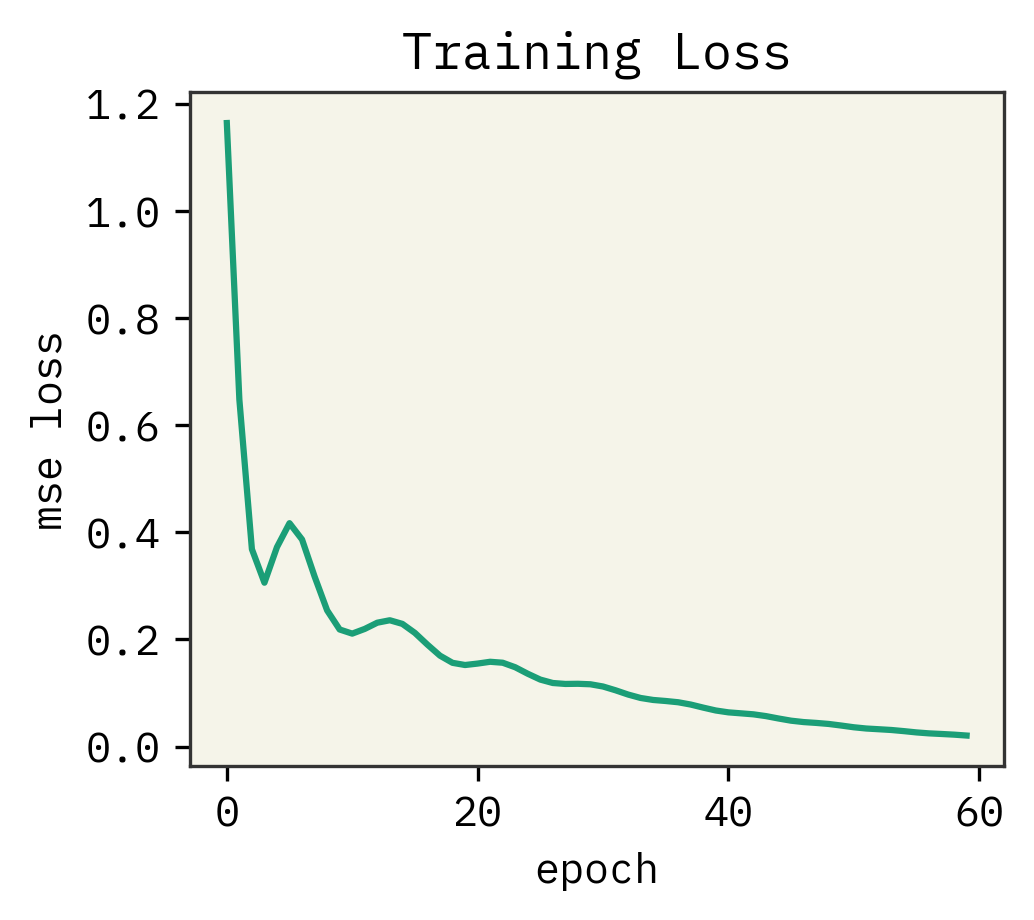

In [5]:
threshold=0
newdata = filterdata_by_label(data, threshold, omitregion='above')
omission_model = mlp(Din,hidden_dim)
optimizer = torch.optim.Adam(omission_model.parameters(), lr=0.01)
losses = train(omission_model, newdata, optimizer, num_epochs)

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.show()

<ipython-input-3-38d11abf5c3f>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, yhat = torch.tensor(y), torch.tensor(yhat)


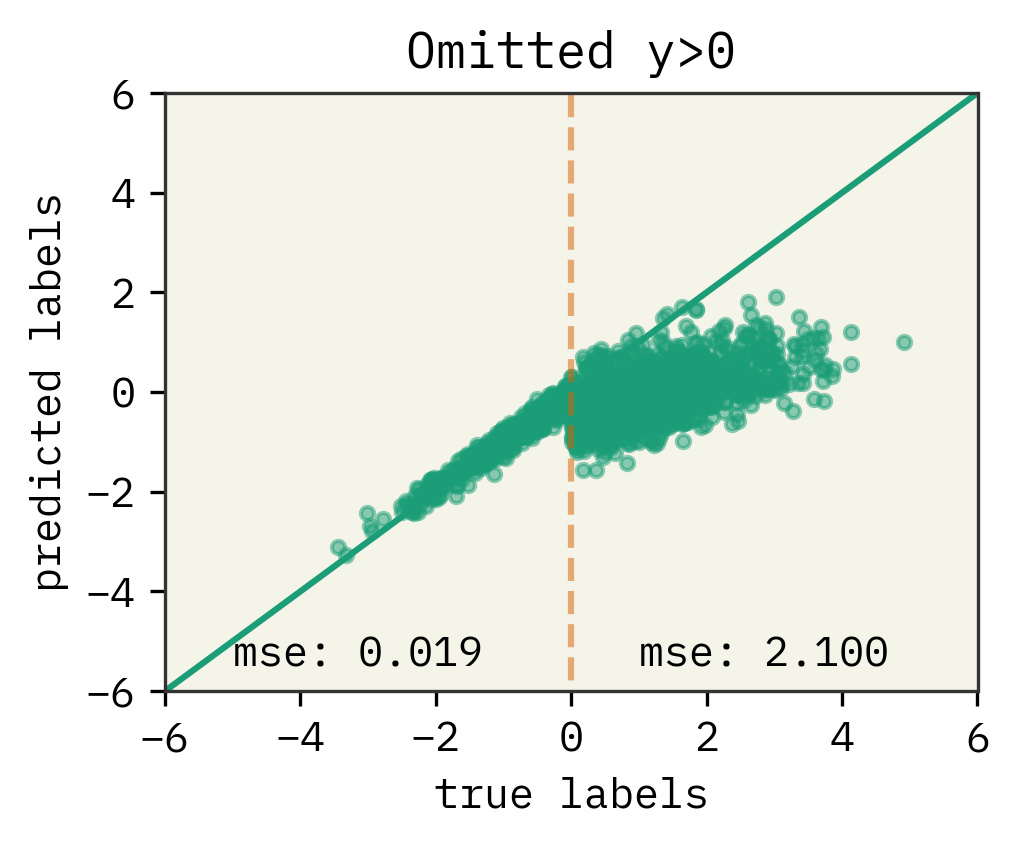

In [6]:
omission_model.eval()
with torch.no_grad():
  y_pred = omission_model(features).detach().numpy()
y_true = labels

th = 0 #threshold
lower_mse = local_mse(y_true,y_pred, -100, th)
upper_mse = local_mse(y_true,y_pred, th, 100)

#plt.title('Original')
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
plt.plot([-10,10],[-10,10])
plt.plot([th,th],[-10,10],'--',alpha=0.5)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.text(-5,-6+0.5,f'mse: {lower_mse:.3f}')
plt.text(1,-6+0.5,f'mse: {upper_mse:.3f}')
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.title('Omitted y>0')
plt.tight_layout()
plt.savefig('mlp_omission.png',dpi=300)
plt.show()

###### Baseline (no noise added)

Epoch [0/60], Loss: 2.1989
Epoch [10/60], Loss: 0.5418
Epoch [20/60], Loss: 0.3837
Epoch [30/60], Loss: 0.2929
Epoch [40/60], Loss: 0.2149
Epoch [50/60], Loss: 0.1474


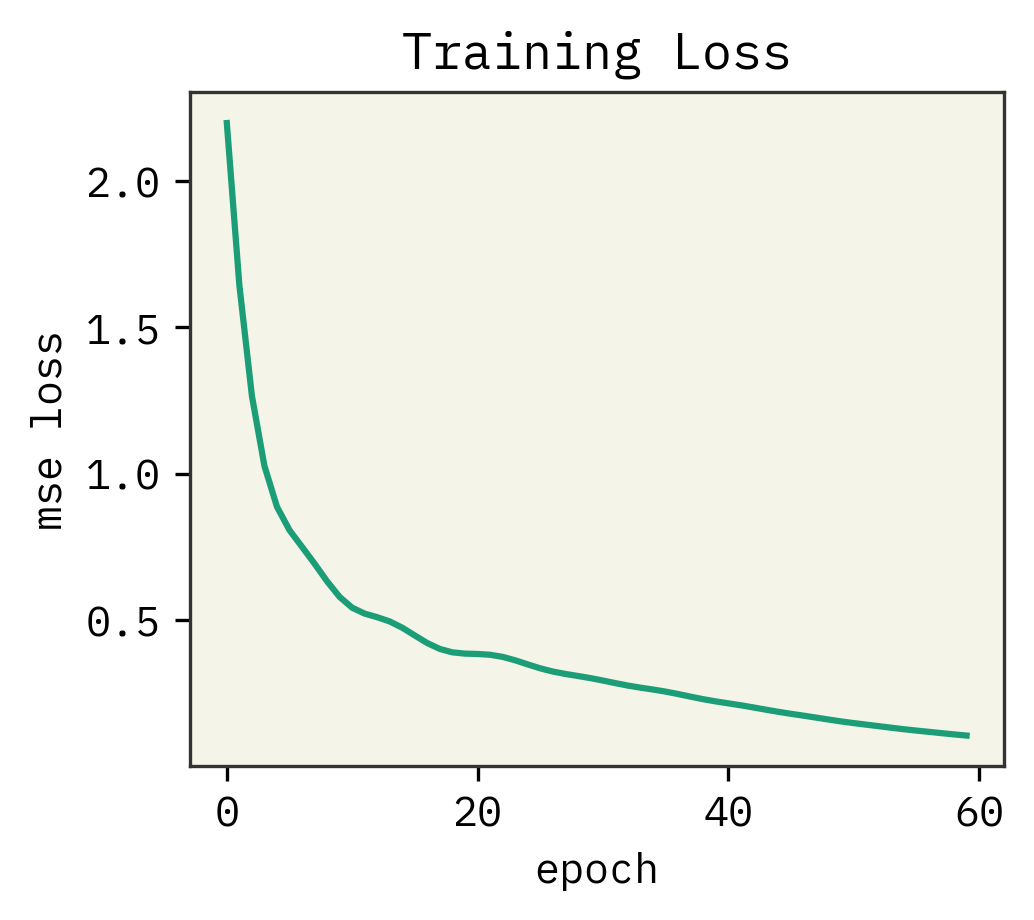

In [7]:
baseline_model = mlp(Din,hidden_dim)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.01)
losses = train(baseline_model, data, optimizer, num_epochs)

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.show()

<ipython-input-3-38d11abf5c3f>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, yhat = torch.tensor(y), torch.tensor(yhat)


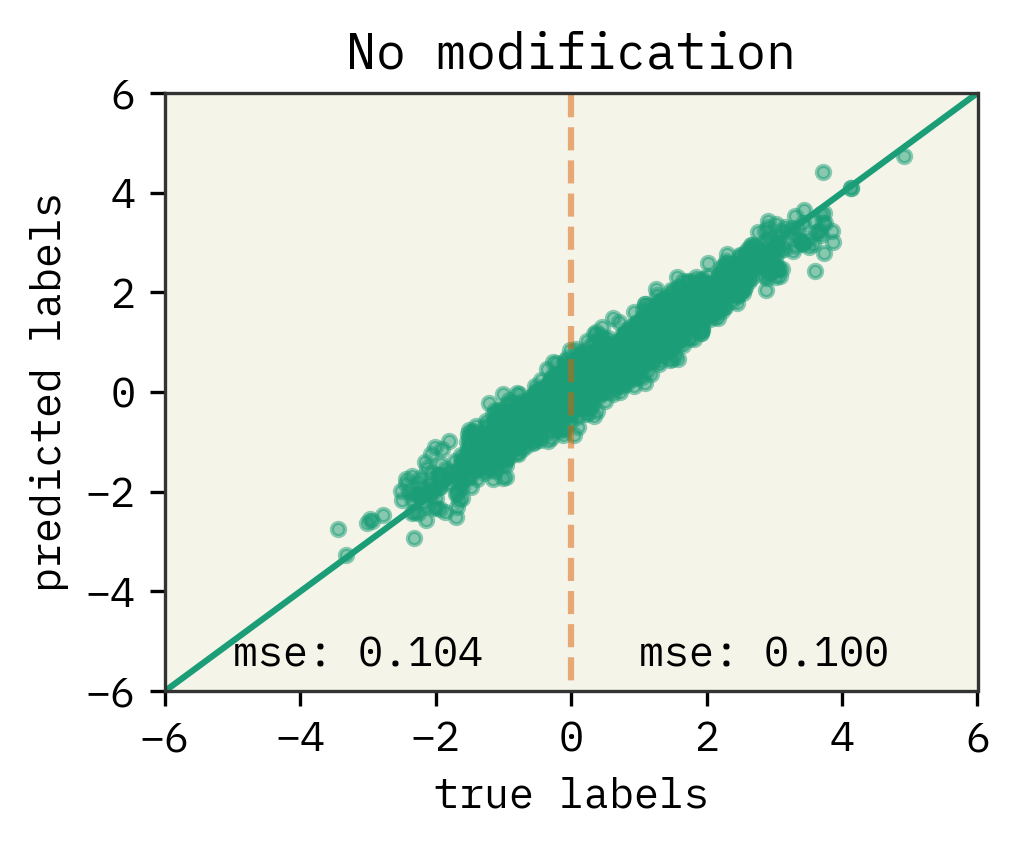

In [8]:
baseline_model.eval()
with torch.no_grad():
  y_pred = baseline_model(features).detach().numpy()
y_true = labels

th = 0 #threshold
lower_mse = local_mse(y_true,y_pred, -100, th)
upper_mse = local_mse(y_true,y_pred, th, 100)

#plt.title('Original')
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
plt.plot([-10,10],[-10,10])
plt.plot([th,th],[-10,10],'--',alpha=0.5)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.text(-5,-6+0.5,f'mse: {lower_mse:.3f}')
plt.text(1,-6+0.5,f'mse: {upper_mse:.3f}')
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.title('No modification')
plt.tight_layout()
plt.savefig('mlp_nonoise.png',dpi=300)
plt.show()

###### Adding y noise

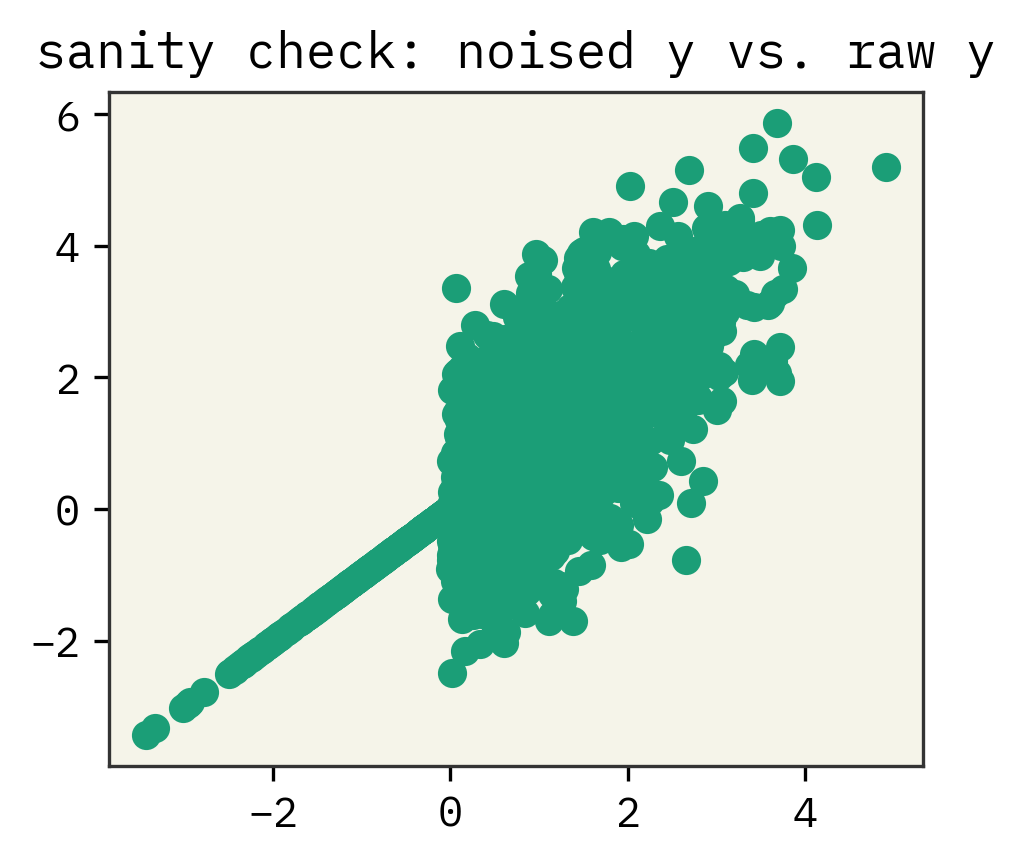

Epoch [0/60], Loss: 2.4640
Epoch [10/60], Loss: 1.1233
Epoch [20/60], Loss: 0.9050
Epoch [30/60], Loss: 0.7281
Epoch [40/60], Loss: 0.5412
Epoch [50/60], Loss: 0.3928


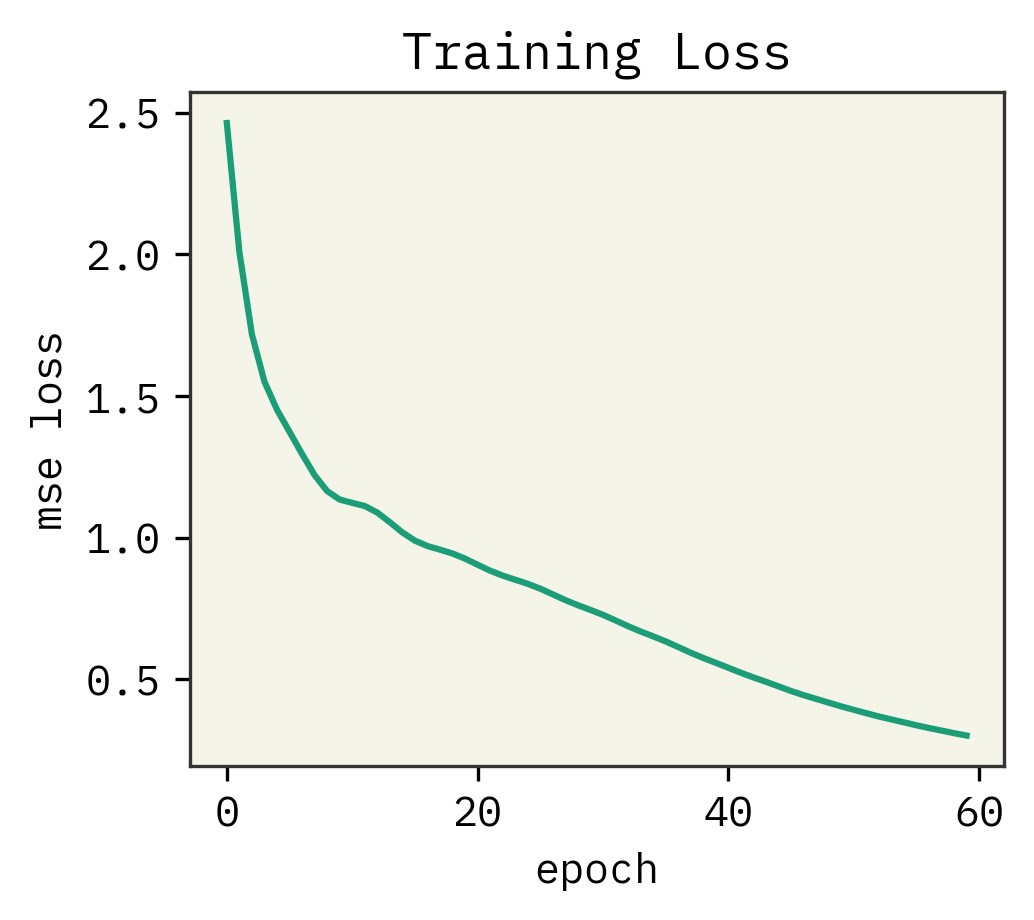

In [9]:
ynoiselevel = 1.0
threshold = 0
ynoiseddata = noising(data, 0, ynoiselevel, threshold, plot=True)

ynoise_model = mlp(Din,hidden_dim)
optimizer = torch.optim.Adam(ynoise_model.parameters(), lr=0.01)
losses = train(ynoise_model, ynoiseddata, optimizer, num_epochs)

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.show()

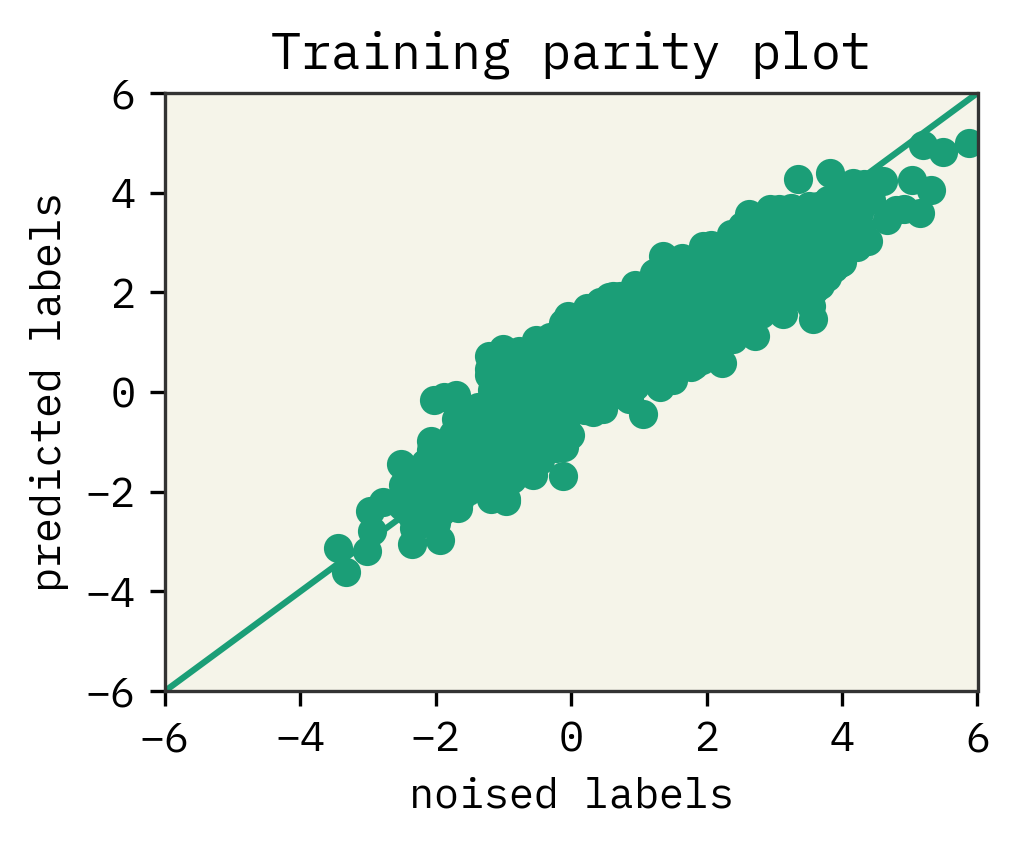

In [10]:
# to ensure it fits the noised data well 
xn, yn = ynoiseddata
ynoise_model.eval()
with torch.no_grad():
  yn_pred = ynoise_model(xn).detach().numpy()

plt.scatter(yn, yn_pred)
plt.title('Training parity plot')
plt.xlabel('noised labels')
plt.ylabel('predicted labels')
plt.plot([-10,10],[-10,10])
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.tight_layout()
plt.show()

<ipython-input-3-38d11abf5c3f>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, yhat = torch.tensor(y), torch.tensor(yhat)


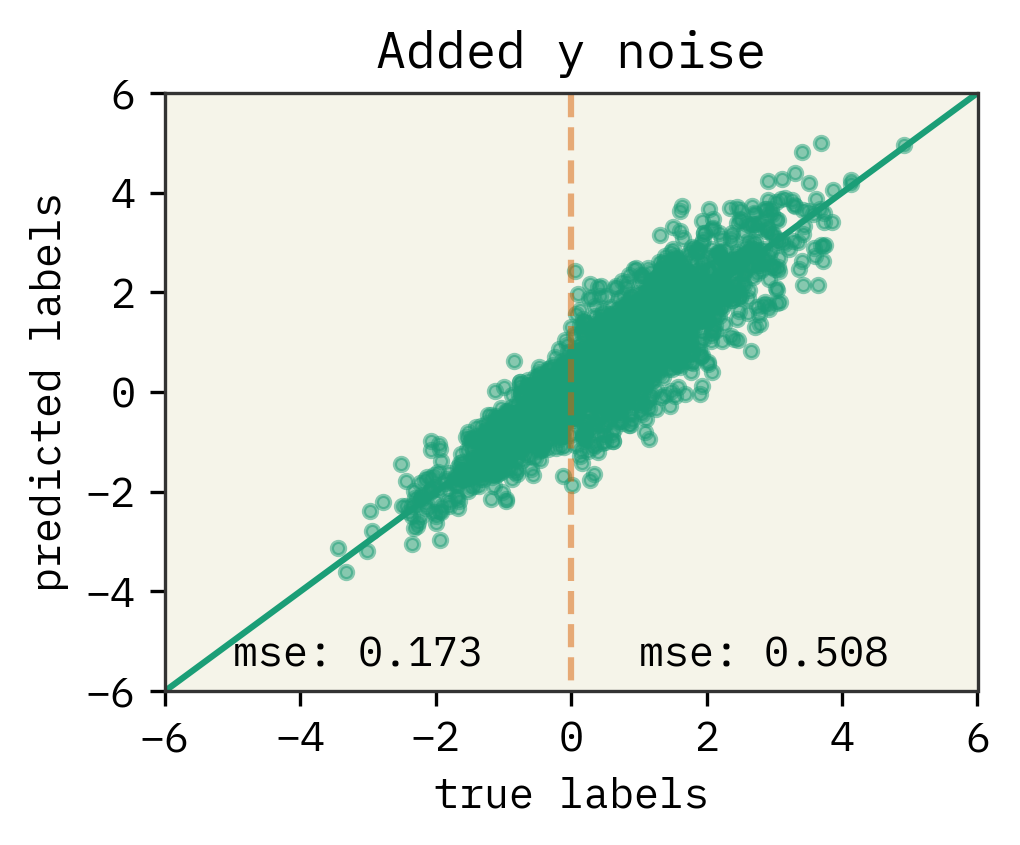

In [11]:
x, y = data
ynoise_model.eval()
with torch.no_grad():
  y_pred = ynoise_model(x).detach().numpy()

th = 0 #threshold
lower_mse = local_mse(y,y_pred, -100, th)
upper_mse = local_mse(y,y_pred, th, 100)

plt.scatter(y,y_pred, s=10, alpha=0.5)
plt.plot([-10,10],[-10,10])
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot([0,0],[-10,10],'--',alpha=0.5)
plt.text(-5,-6+0.5,f'mse: {lower_mse:.3f}')
plt.text(1,-6+0.5,f'mse: {upper_mse:.3f}')
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.title('Added y noise')
plt.tight_layout()
plt.savefig('mlp_ynoise.png',dpi=300)
plt.show()

###### Adding x noise

Epoch [0/60], Loss: 1.3686
Epoch [10/60], Loss: 0.7161
Epoch [20/60], Loss: 0.5169
Epoch [30/60], Loss: 0.3331
Epoch [40/60], Loss: 0.2103
Epoch [50/60], Loss: 0.1406


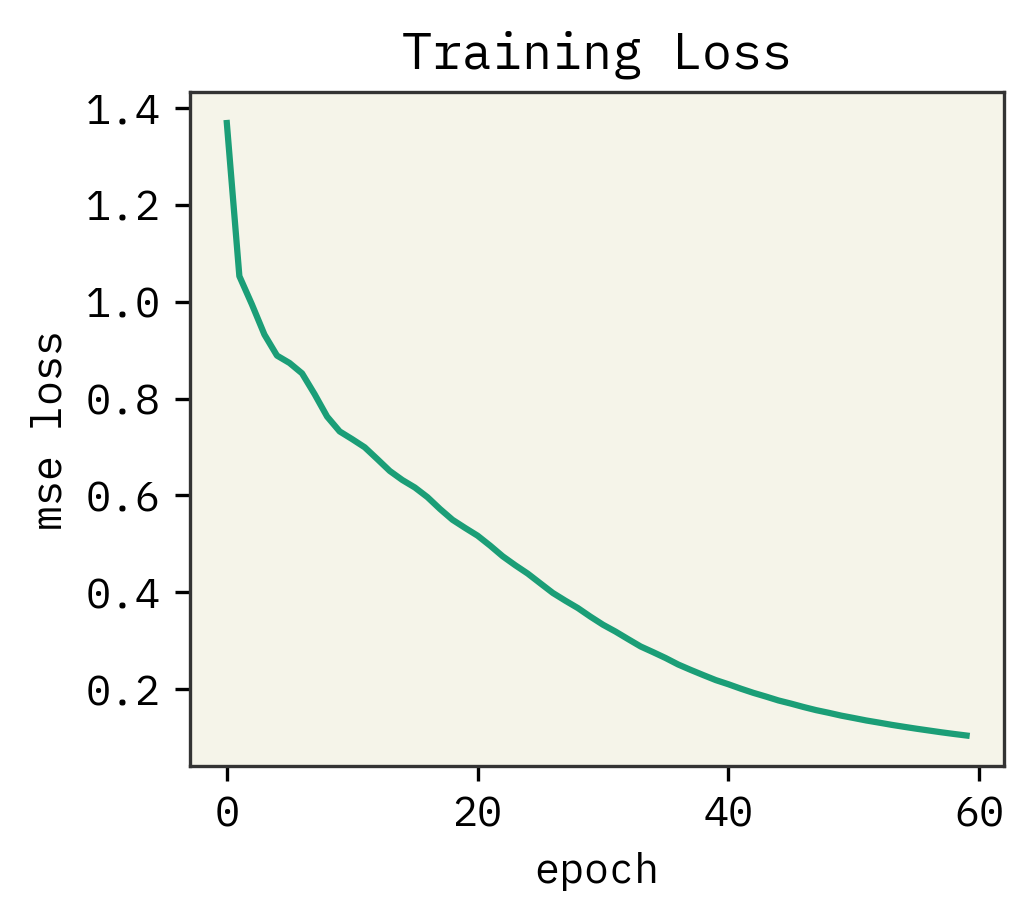

In [12]:
xnoiselevel = 2
threshold = 0
xnoiseddata = noising(data, xnoiselevel, 0, threshold, plot=False)

xnoise_model = mlp(Din,hidden_dim)
optimizer = torch.optim.Adam(xnoise_model.parameters(), lr=0.01)
losses = train(xnoise_model, xnoiseddata, optimizer, num_epochs)

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.show()

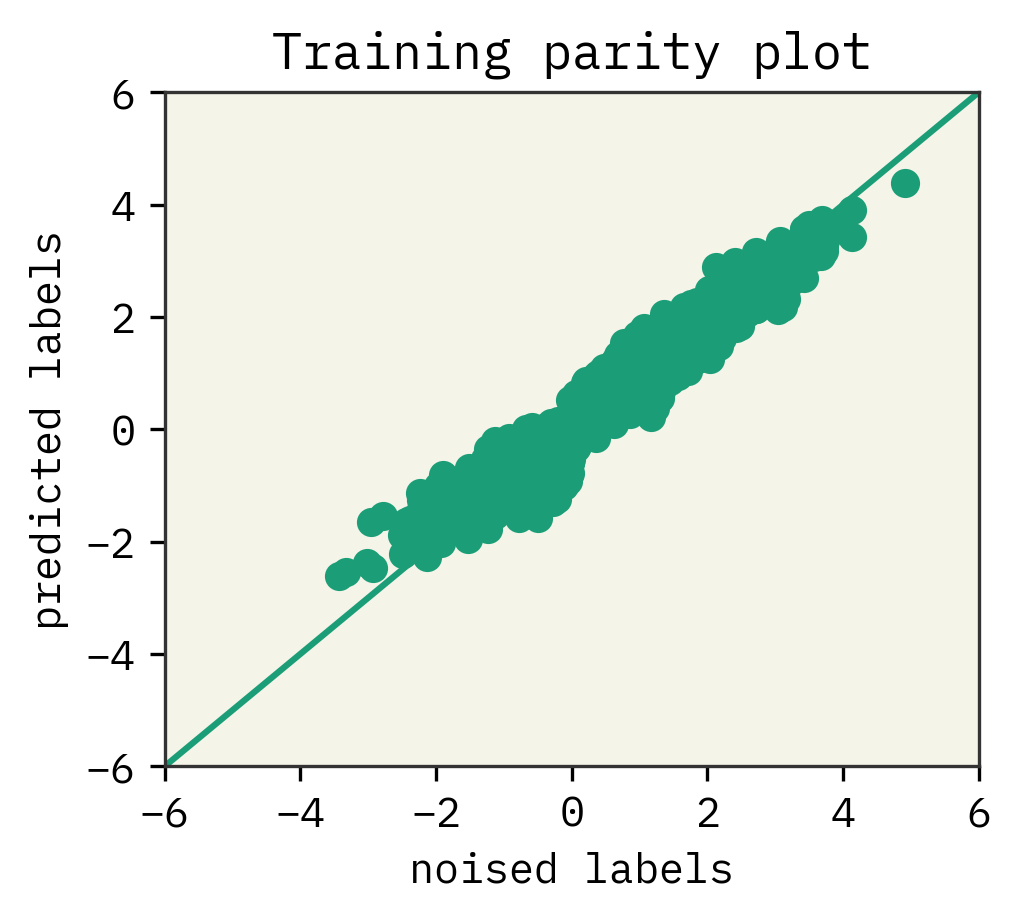

In [13]:
# to ensure it fits the noised data well 
xn, yn = xnoiseddata
xnoise_model.eval()
with torch.no_grad():
  yn_pred = xnoise_model(xn).detach().numpy()

plt.scatter(yn, yn_pred)
plt.title('Training parity plot')
plt.xlabel('noised labels')
plt.ylabel('predicted labels')
plt.plot([-10,10],[-10,10])
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.show()

<ipython-input-3-38d11abf5c3f>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, yhat = torch.tensor(y), torch.tensor(yhat)


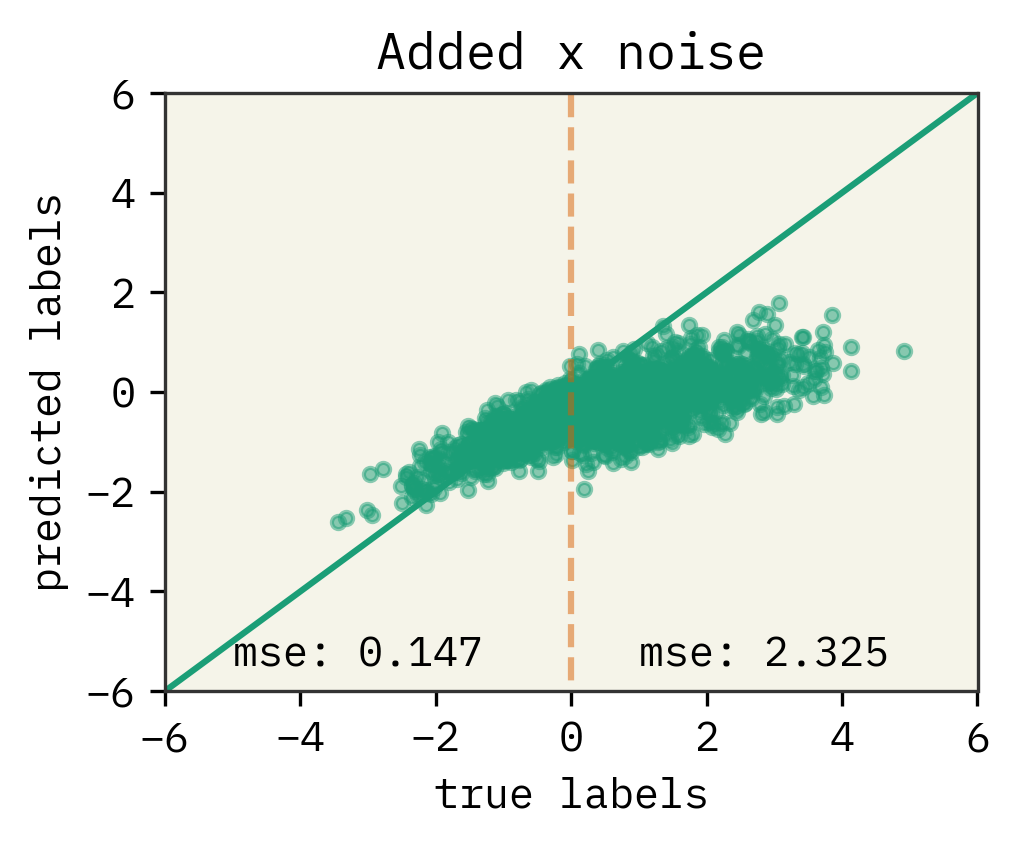

In [14]:
x, y = data
xnoise_model.eval()
with torch.no_grad():
  y_pred = xnoise_model(x).detach().numpy()

lower_mse = local_mse(y,y_pred, -100, th)
upper_mse = local_mse(y,y_pred, th, 100)

plt.scatter(y, y_pred, s=10, alpha=0.5)
plt.plot([-10,10],[-10,10])
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.text(-5,-6+0.5,f'mse: {lower_mse:.3f}')
plt.text(1,-6+0.5,f'mse: {upper_mse:.3f}')
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.title('Added x noise')
plt.plot([0,0],[-10,10],'--',alpha=0.5)
plt.tight_layout()
plt.savefig('mlp_xnoise.png',dpi=300)
plt.show()